# 宏观因子策略Demo

在此demo中，我们从RQdata数据库中挖掘一些基础宏观因子用以预测螺纹钢主力合约收益，并尝试三种常见机器学习模型对收益进行建模。我们基于三种模型的预测结果，以及他们的模型融合的预测结果，分别构建浮动杠杆策略（仓位方向=预测收益方向，仓位规模~|预测收益数值|），并分别进行样本外回测，收益风险比可观。

一些思考：

- 若将此Demo中的策略与CTA策略组合（二者相关性不高），有机会博取更高收益风险比。

- 宏观数据发布频率一般为月度，且具有滞后性，单纯的基于宏观因子策略在实际交易中可能无法及时对市场状态切换做出反应。

- 过去十余年间商品行情状态多变，宏观因子预测力有可能随时间变化增强或衰弱，而此Demo并未考虑。

- 按照此Demo中的逻辑，更多基础宏观因子不难挖掘，且有构建深度因子的条件。

In [1]:
import pandas as pd
import numpy as np

In [2]:
def abs2return(s, p):
    '''
    将绝对量转化为增长率
    s : array
    p : look-back period
    '''
    return np.append(np.repeat(np.NAN, p), (s[p:] - s[:-p])/s[:-p])

def lagging(s, p):
    '''
    平移时间序列
    s : array
    p : lagging period
    '''
    if p > 0:
        return np.append(np.repeat(np.NAN, p), s[:-p])
    if p < 0:
        return np.append(s[-p:], np.repeat(np.NAN, -p))
    if p == 0:
        return s

def to_pm(s):
    '''
    提取序列中的正负号 ( e.g. [-3, 2, -2, 3] -> [-1, 1, -1, 1] )
    s : array
    '''
    s_pm = np.zeros(s.shape)
    for i in range(len(s)):
        if s[i] > 0:
            s_pm[i] = 1
        if s[i] < 0:
            s_pm[i] = -1
    return s_pm

# 数据处理

In [3]:
rb_1d = pd.read_csv('rb_1d.csv')
rb_1d['year'] = pd.to_datetime(rb_1d['date']).dt.year
rb_1d['month'] = pd.to_datetime(rb_1d['date']).dt.month
# 做商复权
# rb_1d['last_settlement'] = rb_1d.groupby('dominant_id').settlement.transform('last')
# rb_1d['first_settlement'] = rb_1d.groupby('dominant_id').settlement.transform('first')
ex_factors = np.append(1, (rb_1d.groupby('dominant_id').settlement.head(1).values / 
    lagging(rb_1d.groupby('dominant_id').settlement.tail(1).values, 1))[1:])
rb_1d['ex_factors'] = np.repeat(ex_factors, rb_1d.groupby('dominant_id').size().values)
rb_1d['settlement_adj'] = rb_1d['settlement']/rb_1d['ex_factors']

In [4]:
rb_1mo = rb_1d.copy().groupby(['year', 'month']).tail(1).set_index(['year', 'month'], drop=True)
rb_1mo['rb_return'] = abs2return(rb_1mo['settlement_adj'].values, 1)
rb_1mo = rb_1mo[['rb_return', 'settlement_adj']]
rb_1mo

rb_return  settlement_adj
year month                           
2010 1            NaN     4298.000000
     2      -0.023732     4196.000000
     3       0.027718     4312.302703
     4      -0.031723     4175.504865
     5      -0.080712     3838.492973
...               ...             ...
2021 9       0.059055     5595.890617
     10     -0.169765     4645.906708
     11     -0.029573     4508.512399
     12      0.038638     4682.712347
2022 1       0.012090     4739.327330

[145 rows x 2 columns]

In [5]:
ms = pd.read_csv('ms.csv')
ms['year'] = pd.to_datetime(ms['effective_date']).dt.year
ms['month'] = pd.to_datetime(ms['effective_date']).dt.month
ms = ms.set_index(['year', 'month'], drop = True)[['m0', 'm1', 'm2']]
ms

m0          m1           m2
year month                                    
2008 12     3421896.0  16621713.0   47516660.0
2009 1      4108237.0  16521434.0   49613531.0
     2      3514164.0  16614960.0   50670807.0
     3      3374642.0  17654113.0   53062671.0
     4      3425727.0  17821357.0   54048121.0
...               ...         ...          ...
2021 7      8470000.0  62040000.0  230220000.0
     8      8505920.0  62665869.0  231226768.0
     9      8686709.0  62464568.0  234282970.0
     10     8608578.0  62608212.0  233616048.0
     11     8743341.0  63748204.0  235601276.0

[156 rows x 3 columns]

In [6]:
econ = pd.read_csv('econ.csv')
econ['year'] = pd.to_datetime(econ['end_date']).dt.year
econ['month'] = pd.to_datetime(econ['end_date']).dt.month
econ = econ.set_index(['year', 'month'], drop = True).drop(columns=['end_date'])
econ

租房CPI  原材料库存PMI  产成品库存PMI
year month                                
2009 12     100.300000      51.4      47.1
2010 1      100.149483      52.2      47.3
     2      100.222679      48.1      47.3
     3      100.339459      50.6      48.3
     4      100.521532      51.5      46.2
...                ...       ...       ...
2021 7      100.100000      47.7      47.6
     8      100.200000      47.7      47.7
     9      100.000000      48.2      47.2
     10      99.900000      47.0      46.3
     11      99.800000      47.7      47.9

[144 rows x 3 columns]

In [7]:
df = pd.concat([rb_1mo, ms, econ], axis = 1, join = 'outer')
df

rb_return  settlement_adj         m0          m1           m2  \
year month                                                                  
2008 12           NaN             NaN  3421896.0  16621713.0   47516660.0   
2009 1            NaN             NaN  4108237.0  16521434.0   49613531.0   
     2            NaN             NaN  3514164.0  16614960.0   50670807.0   
     3            NaN             NaN  3374642.0  17654113.0   53062671.0   
     4            NaN             NaN  3425727.0  17821357.0   54048121.0   
...               ...             ...        ...         ...          ...   
2021 9       0.059055     5595.890617  8686709.0  62464568.0  234282970.0   
     10     -0.169765     4645.906708  8608578.0  62608212.0  233616048.0   
     11     -0.029573     4508.512399  8743341.0  63748204.0  235601276.0   
     12      0.038638     4682.712347        NaN         NaN          NaN   
2022 1       0.012090     4739.327330        NaN         NaN          NaN   

            租房CPI  原材料库存PMI  产成品库存PMI  
year month                             
2008 12       NaN       NaN       NaN  
2009 1        NaN       NaN       NaN  
     2        NaN       NaN       NaN  
     3        NaN       NaN       NaN  
     4        NaN       NaN       NaN  
...           ...       ...       ...  
2021 9      100.0      48.2      47.2  
     10      99.9      47.0      46.3  
     11      99.8      47.7      47.9  
     12       NaN       NaN       NaN  
2022 1        NaN       NaN       NaN  

[158 rows x 8 columns]

# 因子挖掘

In [8]:
def pearson(s1, s2):
    '''
    计算s1和s2的Pearson相关性
    '''
    nas = np.logical_or(np.isnan(s1), np.isnan(s2))
    return np.corrcoef(s1[~nas], s2[~nas])[0, 1]

In [9]:
def corrMatrix(df, col1, col2, N):
    cm = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            cm[i][j] = pearson(df[col1].values, lagging(abs2return(df[col2].values, i+1), j+1))
    return pd.DataFrame(cm).rename(lambda x: '观测长度 ' + str(x+1), axis = 0) \
                           .rename(lambda x: '滞后长度 ' + str(x+1), axis = 1)

In [10]:
# corrMatrix(df, 'rb_return', 'settlement_adj', 6).style \
#     .highlight_max(color = 'lightgreen', axis = None) \
#     .highlight_min(color = 'pink', axis = None)

In [11]:
corrMatrix(df, 'rb_return', 'm0', 6).style \
    .highlight_max(color = 'lightgreen', axis = None) \
    .highlight_min(color = 'pink', axis = None)

,滞后长度 1,滞后长度 2,滞后长度 3,滞后长度 4,滞后长度 5,滞后长度 6
观测长度 1,-0.043660,0.031915,0.088879,-0.148622,0.065605,0.193905
观测长度 2,-0.011084,0.093250,-0.036993,-0.070856,0.193750,0.148056
观测长度 3,0.050405,-0.005251,0.004435,0.059086,0.181596,0.013773
观测长度 4,-0.039662,0.033524,0.125481,0.061284,0.057669,-0.075453
观测长度 5,-0.000493,0.146348,0.122664,-0.057298,-0.029278,-0.056734
观测长度 6,0.109592,0.143789,0.008763,-0.136091,-0.015279,-0.045609


In [12]:
corrMatrix(df, 'rb_return', 'm1', 6).style \
    .highlight_max(color = 'lightgreen', axis = None) \
    .highlight_min(color = 'pink', axis = None)

,滞后长度 1,滞后长度 2,滞后长度 3,滞后长度 4,滞后长度 5,滞后长度 6
观测长度 1,0.231084,-0.103547,0.131791,0.069065,-0.166263,0.068605
观测长度 2,0.103865,0.026359,0.162928,-0.079773,-0.079344,0.217180
观测长度 3,0.195343,0.075051,0.027957,-0.022634,0.073276,0.290219
观测长度 4,0.216839,-0.041952,0.068950,0.106954,0.150516,0.263065
观测长度 5,0.103897,0.003355,0.191767,0.184232,0.151968,0.292931
观测长度 6,0.137917,0.121476,0.253729,0.177015,0.182145,0.177664


In [13]:
corrMatrix(df, 'rb_return', 'm2', 6).style \
    .highlight_max(color = 'lightgreen', axis = None) \
    .highlight_min(color = 'pink', axis = None)

,滞后长度 1,滞后长度 2,滞后长度 3,滞后长度 4,滞后长度 5,滞后长度 6
观测长度 1,0.137519,-0.163408,-0.057928,-0.023426,-0.077088,-0.012017
观测长度 2,-0.020476,-0.171325,-0.063718,-0.078051,-0.069923,0.042412
观测长度 3,-0.054623,-0.160031,-0.104288,-0.073991,-0.015476,-0.013376
观测长度 4,-0.056171,-0.169084,-0.090790,-0.024088,-0.051919,-0.048702
观测长度 5,-0.087200,-0.158907,-0.050468,-0.057169,-0.081318,0.007788
观测长度 6,-0.086787,-0.119362,-0.080338,-0.085727,-0.027487,0.021214


In [14]:
corrMatrix(df, 'rb_return', '租房CPI', 6).style \
    .highlight_max(color = 'lightgreen', axis = None) \
    .highlight_min(color = 'pink', axis = None)

,滞后长度 1,滞后长度 2,滞后长度 3,滞后长度 4,滞后长度 5,滞后长度 6
观测长度 1,0.188404,-0.227675,-0.145149,0.204150,0.096075,-0.068686
观测长度 2,-0.029975,-0.281552,0.043169,0.224881,0.018403,-0.007881
观测长度 3,-0.136126,-0.125458,0.111859,0.168981,0.059905,-0.069989
观测长度 4,0.015426,-0.053939,0.061698,0.207321,-0.002772,-0.150010
观测长度 5,0.095228,-0.105443,0.099166,0.151635,-0.086118,-0.120309
观测长度 6,0.045110,-0.069297,0.036603,0.071439,-0.045950,-0.042835


In [15]:
corrMatrix(df, 'rb_return', '原材料库存PMI', 6).style \
    .highlight_max(color = 'lightgreen', axis = None) \
    .highlight_min(color = 'pink', axis = None)

,滞后长度 1,滞后长度 2,滞后长度 3,滞后长度 4,滞后长度 5,滞后长度 6
观测长度 1,0.030679,-0.007163,0.042257,0.050692,-0.130814,0.002121
观测长度 2,0.016319,0.021025,0.090401,-0.089348,-0.109851,0.043864
观测长度 3,0.052277,0.065495,-0.063889,-0.084884,-0.051676,0.072281
观测长度 4,0.096221,-0.081539,-0.048220,-0.034626,-0.024549,0.092296
观测长度 5,-0.043250,-0.061894,-0.005198,-0.008501,-0.001436,0.030069
观测长度 6,-0.027164,-0.019343,0.020865,0.012429,-0.061142,0.103401


In [16]:
corrMatrix(df, 'rb_return', '产成品库存PMI', 6).style \
    .highlight_max(color = 'lightgreen', axis = None) \
    .highlight_min(color = 'pink', axis = None)

,滞后长度 1,滞后长度 2,滞后长度 3,滞后长度 4,滞后长度 5,滞后长度 6
观测长度 1,0.146388,-0.044584,-0.093114,0.099514,-0.047721,-0.081664
观测长度 2,0.083044,-0.111371,0.006437,0.041824,-0.102304,-0.026356
观测长度 3,0.010017,-0.029305,-0.029076,-0.020916,-0.064487,0.021540
观测长度 4,0.086766,-0.062166,-0.087366,0.007994,-0.018319,0.000829
观测长度 5,0.042988,-0.133038,-0.044712,0.057179,-0.041423,-0.021983
观测长度 6,-0.007001,-0.116325,0.002731,0.042987,-0.085262,-0.093243


In [17]:
df_feat = df[['rb_return']].copy()
# df_feat['settle+'] = lagging(abs2return(df['settlement_adj'].values, 2), 3)
# df_feat['settle-'] = lagging(abs2return(df['settlement_adj'].values, 2), 1)
df_feat['m0+'] = lagging(abs2return(df['m0'].values, 1), 6)
df_feat['m0-'] = lagging(abs2return(df['m0'].values, 1), 4)
df_feat['m1+'] = lagging(abs2return(df['m1'].values, 5), 6)
df_feat['m1-'] = lagging(abs2return(df['m1'].values, 1), 5)
df_feat['m2+'] = lagging(abs2return(df['m2'].values, 1), 1)
df_feat['m2-'] = lagging(abs2return(df['m2'].values, 2), 2)
df_feat['租房CPI+'] = lagging(abs2return(df['租房CPI'].values, 2), 4)
df_feat['租房CPI-'] = lagging(abs2return(df['租房CPI'].values, 2), 2)
df_feat['原材料库存PMI+'] = lagging(abs2return(df['原材料库存PMI'].values, 6), 6)
df_feat['原材料库存PMI-'] = lagging(abs2return(df['原材料库存PMI'].values, 1), 5)
df_feat['产成品库存PMI+'] = lagging(abs2return(df['产成品库存PMI'].values, 1), 1)
df_feat['产成品库存PMI-'] = lagging(abs2return(df['产成品库存PMI'].values, 5), 2)
df_feat.dropna(inplace=True)
df_feat

rb_return       m0+       m0-       m1+       m1-       m2+  \
year month                                                                
2010 12      0.036917  0.006516  0.009600  0.047873  0.000349  0.015094   
2011 1       0.037268  0.016407  0.048385  0.073019  0.015277  0.021839   
     2      -0.009715  0.009600 -0.004974  0.065139 -0.002123  0.011067   
     3      -0.020829  0.048385  0.014550  0.042376  0.038927  0.003060   
     4       0.020438 -0.004974  0.056234  0.071101  0.024109  0.029886   
...               ...       ...       ...       ...       ...       ...   
2021 8      -0.066506  0.025655 -0.008554 -0.014651  0.038123 -0.006731   
     9       0.059055 -0.058537 -0.018946  0.011377 -0.017353  0.004373   
     10     -0.169765 -0.008554  0.001453 -0.021354  0.018840  0.013217   
     11     -0.029573 -0.018946  0.004745 -0.013991  0.033513 -0.002847   
     12      0.038638  0.001453  0.004241  0.019081 -0.026824  0.008498   

                 m2-    租房CPI+    租房CPI-  原材料库存PMI+  原材料库存PMI-  产成品库存PMI+  \
year month                                                                  
2010 12     0.017847 -0.003487 -0.003446  -0.038911  -0.032389   0.043764   
2011 1      0.019911 -0.014629 -0.003212  -0.084291  -0.010460   0.020964   
     2      0.037262 -0.003446  0.001017  -0.016632   0.038055  -0.016427   
     3      0.033147 -0.003212  0.005118  -0.029644   0.008147  -0.031315   
     4      0.014161  0.001017  0.005791  -0.038835   0.004040   0.105603   
...              ...       ...       ...        ...        ...        ...   
2021 8      0.024620 -0.000998  0.000999   0.008457   0.014675   0.010616   
     9      0.011717 -0.001994  0.000000  -0.002062  -0.002066   0.002101   
     10    -0.002387  0.000999  0.000000   0.006250  -0.012422  -0.010482   
     11     0.017648  0.000000 -0.000999  -0.018519   0.006289  -0.019068   
     12     0.010333  0.000000 -0.002994  -0.012346  -0.006250   0.034557   

            产成品库存PMI-  
year month             
2010 12     -0.082329  
2011 1      -0.070175  
     2      -0.024048  
     3       0.021322  
     4       0.031111  
...               ...  
2021 8      -0.038776  
     9      -0.008333  
     10      0.021413  
     11      0.008547  
     12     -0.004301  

[133 rows x 13 columns]

# 预测模型

In [18]:
traindates = pd.period_range('2010-12', '2016-12', freq='M').astype(str)
ntrain = len(traindates)
testdates = pd.period_range('2017-01', '2021-12', freq='M').astype(str)
ntest = len(testdates)

y_train = df_feat.iloc[:ntrain,0].values
X_train = df_feat.iloc[:ntrain,1:].values
y_test = df_feat.iloc[-ntest:,0].values
X_test = df_feat.iloc[-ntest:,1:].values

In [19]:
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
import lightgbm as lgbm
from sklearn.neural_network import MLPRegressor

## 线性回归（LR）

In [20]:
reg = LinearRegression()
reg.fit(X_train, y_train)
lr_pred_train = reg.predict(X_train)
lr_pred_test = reg.predict(X_test)

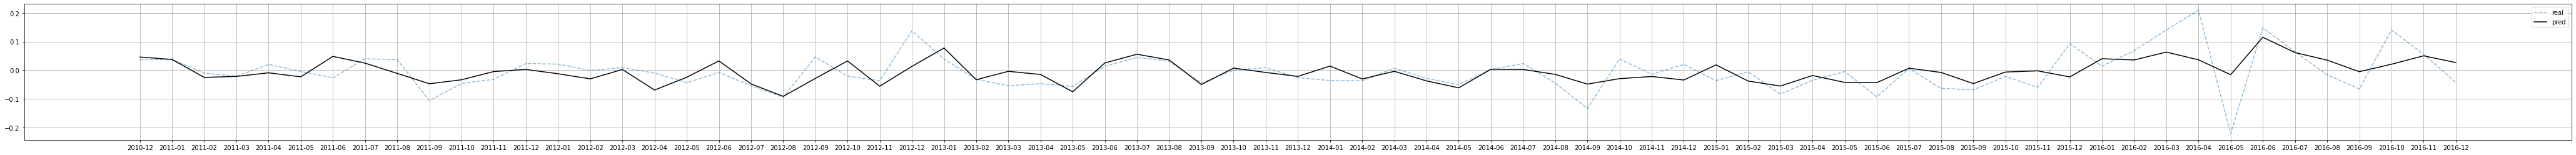

In [21]:
plt.figure(figsize=(ntrain, 4))
plt.plot(traindates, y_train, '--', alpha = 0.5, label = "real")
plt.plot(traindates, lr_pred_train, 'black', label = "pred")
plt.grid()
plt.legend()
plt.show()

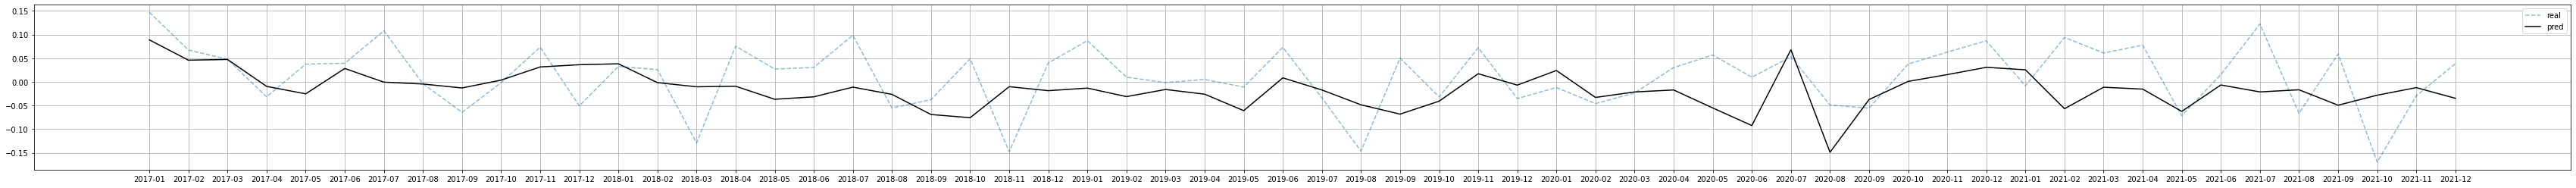

In [22]:
plt.figure(figsize=(ntest, 4))
plt.plot(testdates, y_test, '--', alpha = 0.5, label = "real")
plt.plot(testdates, lr_pred_test, 'black', label = "pred")
plt.grid()
plt.legend()
plt.show()

## 梯度增强树（LGBM)

In [23]:
reg = lgbm.LGBMRegressor(num_leaves = 20, max_depth = 1, learning_rate = 0.01, n_estimators = 1000)
reg.fit(X_train, y_train)
lgbm_pred_train = reg.predict(X_train)
lgbm_pred_test = reg.predict(X_test)

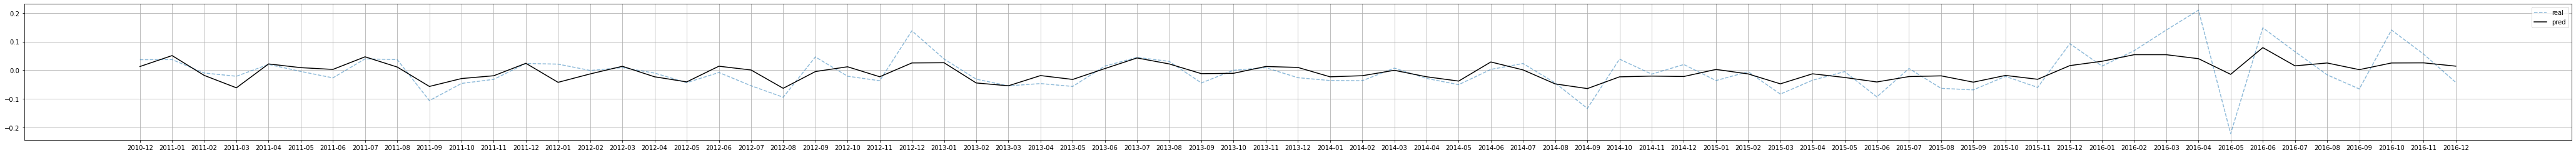

In [24]:
plt.figure(figsize=(ntrain, 4))
plt.plot(traindates, y_train, '--', alpha = 0.5, label = "real")
plt.plot(traindates, lgbm_pred_train, 'black', label = "pred")
plt.grid()
plt.legend()
plt.show()

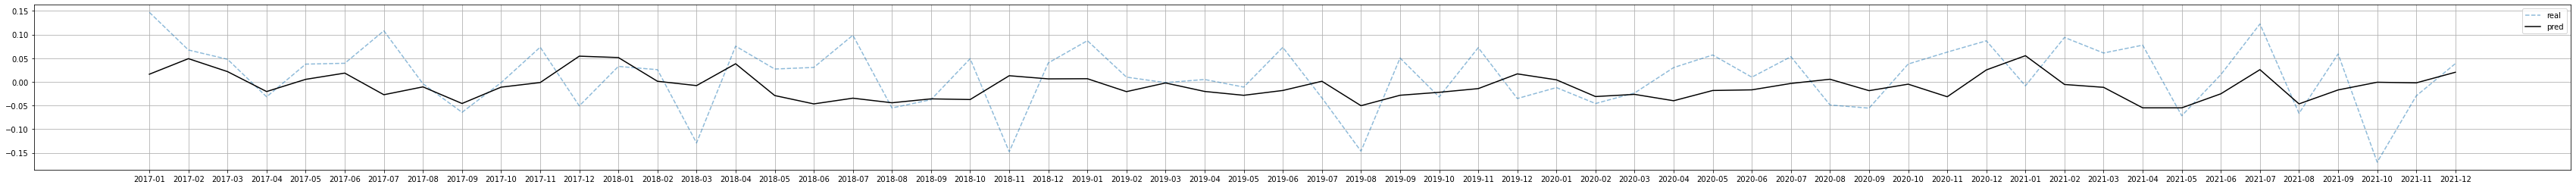

In [25]:
plt.figure(figsize=(ntest, 4))
plt.plot(testdates, y_test, '--', alpha = 0.5, label = "real")
plt.plot(testdates, lgbm_pred_test, 'black', label = "pred")
plt.grid()
plt.legend()
plt.show()

## 多层感知器（MLP）

In [26]:
reg = MLPRegressor(hidden_layer_sizes = (40, 40), max_iter = 1000, alpha = 0.001, learning_rate_init = 0.01)
mlp_pred_train = 0
mlp_pred_test = 0
for i in range(100):
    reg.fit(X_train, y_train)
    mlp_pred_train += reg.predict(X_train)
    mlp_pred_test += reg.predict(X_test)
mlp_pred_train = mlp_pred_train/100
mlp_pred_test = mlp_pred_test/100

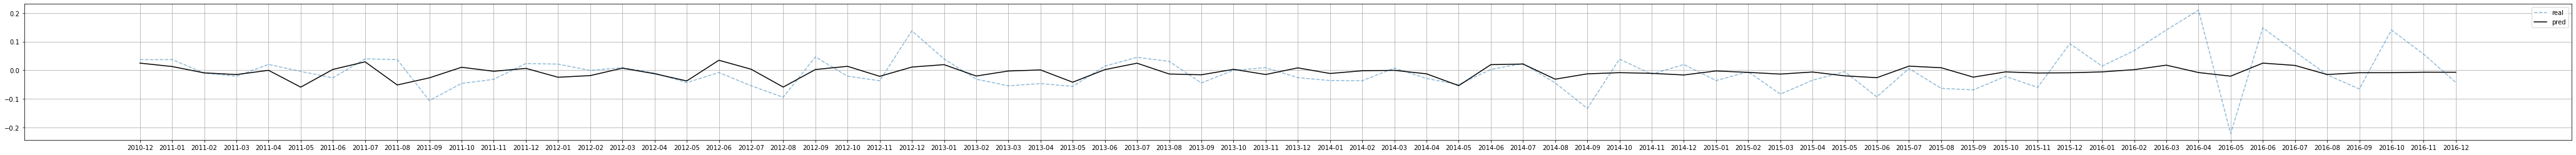

In [27]:
plt.figure(figsize=(ntrain, 4))
plt.plot(traindates, y_train, '--', alpha = 0.5, label = "real")
plt.plot(traindates, mlp_pred_train, 'black', label = "pred")
plt.grid()
plt.legend()
plt.show()

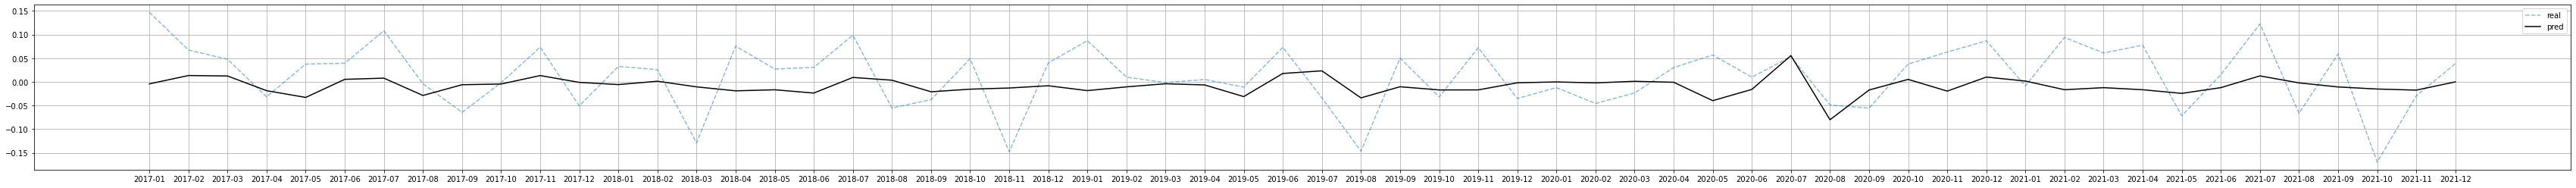

In [28]:
plt.figure(figsize=(ntest, 4))
plt.plot(testdates, y_test, '--', alpha = 0.5, label = "real")
plt.plot(testdates, mlp_pred_test, 'black', label = "pred")
plt.grid()
plt.legend()
plt.show()

# 浮动杠杆策略 & 样本外回测

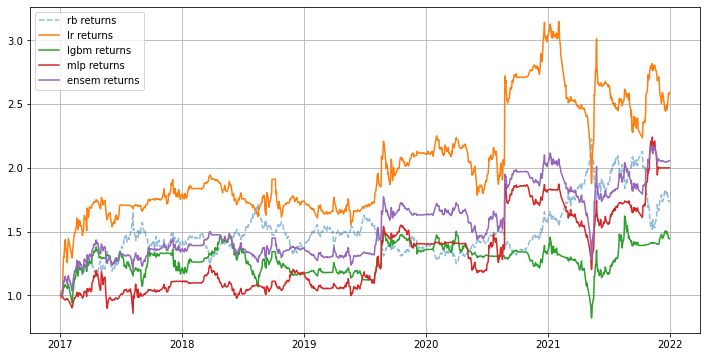

In [29]:
df_pred = rb_1mo.copy().reset_index().drop(columns='settlement_adj')
df_pred = df_pred.merge(pd.DataFrame({'year':pd.to_datetime(testdates).year, 'month':pd.to_datetime(testdates).month}))
df_pred['lr_pred'] = lr_pred_test
df_pred['lgbm_pred'] = lgbm_pred_test
df_pred['mlp_pred'] = mlp_pred_test
df_pred['lr_lever'] = df_pred['lr_pred']/np.mean(np.abs(lr_pred_train))
df_pred['lgbm_lever'] = df_pred['lgbm_pred']/np.mean(np.abs(lgbm_pred_train))
df_pred['mlp_lever'] = df_pred['mlp_pred']/np.mean(np.abs(mlp_pred_train))
df_pred = df_pred.merge(rb_1d, on = ['year', 'month'])[['date', 'year', 'month', 'settlement_adj', 'lr_lever', 'lgbm_lever', 'mlp_lever']]
df_pred['return'] = abs2return(df_pred['settlement_adj'].values, 1)
df_pred['lr_return'] = df_pred['lr_lever'] * df_pred['return']
df_pred['lgbm_return'] = df_pred['lgbm_lever'] * df_pred['return']
df_pred['mlp_return'] = df_pred['mlp_lever'] * df_pred['return']
df_pred['ensem_return'] = (df_pred['lr_lever'] + df_pred['lgbm_lever'] + df_pred['mlp_lever'])/3 * df_pred['return']
df_pred['cum_return'] = np.cumprod(np.repeat(1, len(df_pred)) +  df_pred['return']).fillna(1)
df_pred['lr_cum_return'] = np.cumprod(np.repeat(1, len(df_pred)) + df_pred['lr_return']).fillna(1)
df_pred['lgbm_cum_return'] = np.cumprod(np.repeat(1, len(df_pred)) + df_pred['lgbm_return']).fillna(1)
df_pred['mlp_cum_return'] = np.cumprod(np.repeat(1, len(df_pred)) + df_pred['mlp_return']).fillna(1)
df_pred['ensem_cum_return'] = np.cumprod(np.repeat(1, len(df_pred)) + df_pred['ensem_return']).fillna(1)

plt.figure(figsize = (12, 6))
plt.plot(pd.to_datetime(df_pred.date), df_pred.cum_return, '--', alpha = 0.5, label = "rb returns")
plt.plot(pd.to_datetime(df_pred.date), df_pred.lr_cum_return, label = "lr returns")
plt.plot(pd.to_datetime(df_pred.date), df_pred.lgbm_cum_return, label = "lgbm returns")
plt.plot(pd.to_datetime(df_pred.date), df_pred.mlp_cum_return, label = "mlp returns")
plt.plot(pd.to_datetime(df_pred.date), df_pred.ensem_cum_return, label = "ensem returns")
plt.legend()
plt.grid()
plt.show()

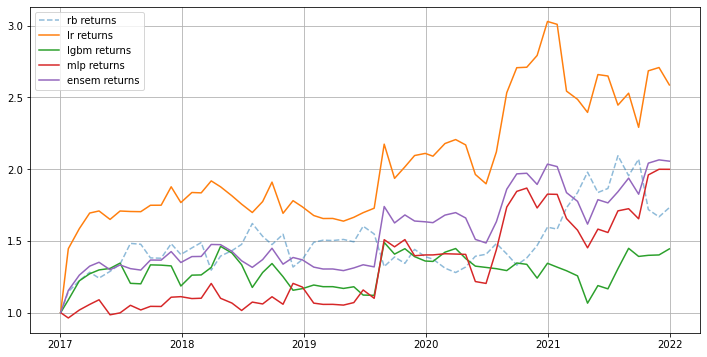

In [32]:
df_pred_mo = pd.concat([df_pred.head(1), df_pred.groupby(['year', 'month']).tail(1)])

plt.figure(figsize = (12, 6))
plt.plot(pd.to_datetime(df_pred_mo.date), df_pred_mo.cum_return, '--', alpha = 0.5, label = "rb returns")
plt.plot(pd.to_datetime(df_pred_mo.date), df_pred_mo.lr_cum_return, label = "lr returns")
plt.plot(pd.to_datetime(df_pred_mo.date), df_pred_mo.lgbm_cum_return, label = "lgbm returns")
plt.plot(pd.to_datetime(df_pred_mo.date), df_pred_mo.mlp_cum_return, label = "mlp returns")
plt.plot(pd.to_datetime(df_pred_mo.date), df_pred_mo.ensem_cum_return, label = "ensem returns")

plt.legend()
plt.grid()
plt.show()